<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Modeling-and-Simulation-in-Python" data-toc-modified-id="Modeling-and-Simulation-in-Python-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling and Simulation in Python</a></span><ul class="toc-item"><li><span><a href="#One-queue-or-two?" data-toc-modified-id="One-queue-or-two?-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>One queue or two?</a></span><ul class="toc-item"><li><span><a href="#One-server,-one-queue" data-toc-modified-id="One-server,-one-queue-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>One server, one queue</a></span></li><li><span><a href="#Parameter-sweep" data-toc-modified-id="Parameter-sweep-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Parameter sweep</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Analysis</a></span></li><li><span><a href="#Multiple-servers" data-toc-modified-id="Multiple-servers-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Multiple servers</a></span></li><li><span><a href="#Multiple-queues" data-toc-modified-id="Multiple-queues-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Multiple queues</a></span></li></ul></li></ul></li></ul></div>

# Modeling and Simulation in Python

MODIFIED HOMEPC

Case Study: Queueing theory

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import numpy as np
# set the random number generator
np.random.seed(7)

In [2]:
pd.options.display.max_rows=20

## One queue or two?

This notebook presents a solution to an exercise from *Modeling and Simulation in Python*.  It uses features from the first four chapters to answer a question related to queueing theory, which is the study of systems that involve waiting in lines, also known as "queues".

Suppose you are designing the checkout area for a new store.  There is room for two checkout counters and a waiting area for customers.  You can make two lines, one for each counter, or one line that serves both counters.

In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you would have to install rope barriers, and customers might be put off by what seems to be a longer line, even if it moves faster.

So you'd like to check whether the single line is really better and by how much.  Simulation can help answer this question.

As we did in the bikeshare model, we'll assume that a customer is equally likely to arrive during any timestep.  I'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`.  The value of $\lambda$ probably varies from day to day, so we'll have to consider a range of possibilities.

Based on data from other stores, you know that it takes 5 minutes for a customer to check out, on average.  But checkout times are highly variable: most customers take less than 5 minutes, but some take substantially more.  A simple way to model this variability is to assume that when a customer is checking out, they have the same probability of finishing up during each time step.  I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.

If we choose $\mu=1/5$, the average number of time steps for each checkout will be 5 minutes, which is consistent with the data.

### One server, one queue

Write a function called `make_system` that takes `lam` and `mu` as parameters and returns a `System` object with variables `lam`, `mu`, and `duration`.  Set `duration`, which is the number of time steps to simulate, to 10 hours, expressed in minutes. 

In [3]:
# Solution goes here
def make_system(lam,mu):   
    # lam denotes the prob that a customer arrive
    # mu denotes the prob that a customer finished checkout
    System = State(lam=lam,mu=mu,duration = 10*60)
    return System

Test this function by creating a `System` object with `lam=1/8` and `mu=1/5`.

In [4]:
System = make_system(1/8,1/5)
System

,values
lam,0.125
mu,0.200
duration,600.000


Write an update function that takes as parameters `x`, which is the total number of customer in the store, including the one checking out; `t`, which is the number of minutes that have elapsed in the simulation, and `system`, which is a `System` object.

If there's a customer checking out, it should use `flip` to decide whether they are done.  And it should use `flip` to decide if a new customer has arrived.

It should return the total number of customers at the end of the time step.


In [5]:
flip?

In [6]:
# Solution goes here
def update_func_1(x,t,system):
    t += 1
    if x>0:
        if flip(system.mu):
            x -= 1
    if flip(system.lam):
        x += 1

    return x

Test your function by calling it with `x=1`, `t=0`, and the `System` object you created.  If you run it a few times, you should see different results.

In [7]:
# Solution goes here
update_func_1(1,0,System)

0

Now we can run the simulation.  Here's a version of `run_simulation` that creates a `TimeSeries` with the total number of customers in the store, including the one checking out.

In [8]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x

    return results

Call `run_simulation` with your update function and plot the results.

In [9]:
# Solution goes here
run_simulation(System,update_func_1)

,values
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,1
8,1
9,2


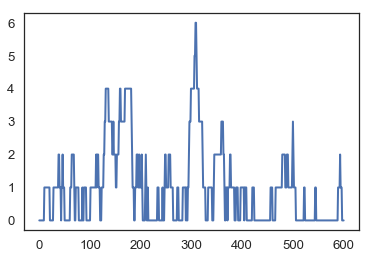

In [10]:
plot(run_simulation(System,update_func_1))

After the simulation, we can compute `L`, which is the average number of customers in the system, and `W`, which is the average time customers spend in the store.  `L` and `W` are related by Little's Law:

$L = \lambda W$

Where $\lambda$ is the arrival rate.  Here's a function that computes them.

In [11]:
def compute_metrics(results, system):
    """Compute average number of customers and wait time.
    
    results: TimeSeries of queue lengths
    system: System object
    
    returns: L, W
    """
    L = results.mean()
    W = L / system.mu
    return L, W

Call `compute_metrics` with the results from your simulation.

In [12]:
# Solution goes here
compute_metrics(run_simulation(System,update_func_1),System)

(1.2845257903494176, 6.422628951747088)

### Parameter sweep

Since we don't know the actual value of $\lambda$, we can sweep through a range of possibilities, from 10% to 80% of the completion rate, $\mu$.  (If customers arrive faster than the completion rate, the queue grows without bound.  In that case the metrics `L` and `W` just depend on how long the store is open.)

Create an array of values for `lam`.

In [13]:
Series_test = pd.Series(dtype='int')

Series_test = Series_test.append(pd.Series([1,2,3],index=['a','b','c']))
# Series_test[1]

a    1
b    2
c    3
dtype: int64

In [14]:
Series_test2 = pd.Series(index=[0,1,2,3,4,5],dtype=int)
Series_test2[1] = 5
Series_test2

0    0
1    5
2    0
3    0
4    0
5    0
dtype: int32

In [15]:
Series_test[0]

1

In [16]:
Series_test.append(pd.Series([10]),ignore_index=True)

0     1
1     2
2     3
3    10
dtype: int64

In [17]:
Dataframe_test = pd.DataFrame(columns = ['mu','lam'])
for i in range(5):
    Dataframe_test = Dataframe_test.append([{'mu':i}],ignore_index = True)

Dataframe_test

G:\Anaconda\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,mu,lam
0,0,NaN
1,1,NaN
2,2,NaN
3,3,NaN
4,4,NaN


Write a function that takes an array of values for `lam`, a single value for `mu`, and an update function.

For each value of `lam`, it should run a simulation, compute `L` and `W`, and store the value of `W` in a `SweepSeries`.

It should return the `SweepSeries`.

In [18]:
# Solution goes here
def create_lam_spectrum(mu):
    lam_list = DataFrame(columns = ['mu','lam'])
    for i in range(8):
        lam_list = lam_list.append([{'lam':0.1*(i+1)*mu,'mu':mu}],ignore_index=True)
    return lam_list

create_lam_spectrum(1/5)

,mu,lam
0,0.2,0.02
1,0.2,0.04
2,0.2,0.06
3,0.2,0.08
4,0.2,0.10
5,0.2,0.12
6,0.2,0.14
7,0.2,0.16


In [19]:
lam_mu_list = create_lam_spectrum(1/5)
lam_mu_list.iloc[0]['mu']

0.2

In [20]:
lam_mu_list.index

RangeIndex(start=0, stop=8, step=1)

Call your function to generate a `SweepSeries`, and plot it.

In [21]:
# Solution goes here
def generate_SweepSeries(lam_mu_list,update_func_1):
    L_values = TimeSeries()
    W_values = TimeSeries()

    for i in lam_mu_list.index:
        System = make_system(lam_mu_list.iloc[i]['lam'],lam_mu_list.iloc[i]['mu'])
        
        L_values[i],W_values[i] = compute_metrics(run_simulation(System,update_func_1),System)

    return W_values

W_values = generate_SweepSeries(lam_mu_list,update_func_1)
W_values_DF = pd.DataFrame(W_values,columns = ['W_value'])
W_values_DF['lam'] = lam_mu_list['lam']
W_values_DF['mu'] = lam_mu_list['mu']
W_values_DF

,W_value,lam,mu
0,0.507488,0.02,0.2
1,1.780366,0.04,0.2
2,2.404326,0.06,0.2
3,5.532446,0.08,0.2
4,4.633943,0.10,0.2
5,7.886855,0.12,0.2
6,8.935108,0.14,0.2
7,14.492512,0.16,0.2


In [22]:
# test_list2 = [0,0,0,0,0]
W_values_DF = pd.DataFrame()
W_values_DF['lam'] = lam_mu_list['lam']
W_values_DF['mu'] = lam_mu_list['mu']

for i in range(10):
    W_values = generate_SweepSeries(lam_mu_list,update_func_1)
    W_values_DF[i] = W_values

W_values_DF

,lam,mu,0,1,2,3,4,5,6,7,8,9
0,0.02,0.2,0.391015,0.366057,0.440932,0.424293,0.440932,0.806988,0.391015,0.440932,0.191348,0.407654
1,0.04,0.2,0.773710,1.547421,1.480865,1.389351,0.906822,0.998336,0.815308,0.848586,1.655574,0.965058
2,0.06,0.2,1.763727,1.780366,3.094842,3.061564,1.331115,1.530782,3.801997,3.602329,1.913478,1.489185
3,0.08,0.2,2.296173,1.971714,3.519135,1.988353,1.663894,3.044925,2.054908,3.094842,3.119800,4.242928
4,0.10,0.2,3.976705,4.276206,4.292845,6.381032,4.101498,4.026622,4.792013,3.036606,3.527454,5.008319
5,0.12,0.2,6.256240,6.422629,5.316140,6.838602,4.933444,10.599002,8.710483,20.948419,8.178037,3.885191
6,0.14,0.2,5.349418,9.251248,6.214642,9.517471,13.003328,8.069884,4.941764,10.565724,32.071547,7.071547
7,0.16,0.2,8.785358,12.720466,11.056572,11.372712,15.149750,6.896839,7.079867,14.101498,11.372712,8.361065


In [23]:
W_values_DF['average10'] = W_values_DF[W_values_DF.columns[2:]].mean(axis = 1)
W_values_DF

,lam,mu,0,1,2,3,4,5,6,7,8,9,average10
0,0.02,0.2,0.391015,0.366057,0.440932,0.424293,0.440932,0.806988,0.391015,0.440932,0.191348,0.407654,0.430116
1,0.04,0.2,0.773710,1.547421,1.480865,1.389351,0.906822,0.998336,0.815308,0.848586,1.655574,0.965058,1.138103
2,0.06,0.2,1.763727,1.780366,3.094842,3.061564,1.331115,1.530782,3.801997,3.602329,1.913478,1.489185,2.336938
3,0.08,0.2,2.296173,1.971714,3.519135,1.988353,1.663894,3.044925,2.054908,3.094842,3.119800,4.242928,2.699667
4,0.10,0.2,3.976705,4.276206,4.292845,6.381032,4.101498,4.026622,4.792013,3.036606,3.527454,5.008319,4.341930
5,0.12,0.2,6.256240,6.422629,5.316140,6.838602,4.933444,10.599002,8.710483,20.948419,8.178037,3.885191,8.208819
6,0.14,0.2,5.349418,9.251248,6.214642,9.517471,13.003328,8.069884,4.941764,10.565724,32.071547,7.071547,10.605657
7,0.16,0.2,8.785358,12.720466,11.056572,11.372712,15.149750,6.896839,7.079867,14.101498,11.372712,8.361065,10.689684


In [24]:
# Solution goes here

If we imagine that this range of values represents arrival rates on different days, we can use the average value of `W`, for a range of values of `lam`, to compare different queueing strategies.

In [25]:
W_avg = W_values.mean()

3.9288685524126454

### Analysis

The model I chose for this system is a common model in queueing theory, in part because many of its properties can be derived analytically.

In particular, we can derive the average time in the store as a function of $\mu$ and $\lambda$:

$W = 1 / (\mu - \lambda)$

The following function plots the theoretical value of $W$ as a function of $\lambda$.

In [26]:
def plot_W(lam_array, mu):
    """Plot the theoretical mean wait time.
    
    lam_array: array of values for `lam`
    mu: probability of finishing a checkout
    """
    W = 1 / (mu - lam_array)
    plot(lam_array, W, 'g-')

Use this function to plot the theoretical results, then plot your simulation results again on the same graph.  How do they compare?

In [27]:
lam_mu_list

,mu,lam
0,0.2,0.02
1,0.2,0.04
2,0.2,0.06
3,0.2,0.08
4,0.2,0.10
5,0.2,0.12
6,0.2,0.14
7,0.2,0.16


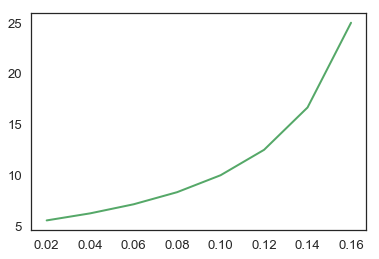

In [28]:
# Solution goes here
plot_W(lam_mu_list['lam'],lam_mu_list['mu'])

### Multiple servers

Now let's try the other two queueing strategies:

1.  One queue with two checkout counters.
2.  Two queues, one for each counter.

The following figure shows the three scenarios:

![](diagrams/queue.png)

Write an update function for one queue with two servers.

In [29]:
# Solution goes here
def update_func_2(x,t,system):
    t += 1
    if x==1:
        if np.random.binomial(1,system.mu):
            x -= 1
    if x>1:
        if np.random.binomial(1,system.mu):
            x -= 1
        if np.random.binomial(1,system.mu):
            x -= 1
    
    if np.random.binomial(1,system.lam):
        x += 1

    return x



In [30]:
System2 = State(lam = 0, mu = 1, duration = 600)

,values
lam,0
mu,1
duration,600


Use this update function to simulate the system, plot the results, and print the metrics.

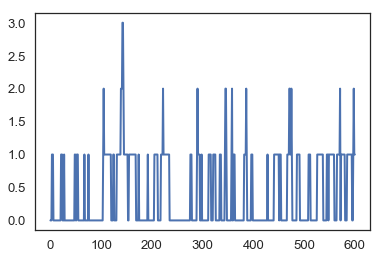

In [31]:
run_simulation(System,update_func_2)
plot(run_simulation(System,update_func_2))

Since we have two checkout counters now, we can consider values for $\lambda$ that exceed $\mu$.

Create a new array of values for `lam` from 10% to 160% of `mu`.

In [32]:
# Solution goes here
def generate_lam_spectrum_new(mu):
    return [(i+1)*0.1*mu for i in range(16)]

new_lam_list = generate_lam_spectrum_new(System.mu)

[0.020000000000000004,
 0.04000000000000001,
 0.06000000000000001,
 0.08000000000000002,
 0.1,
 0.12000000000000002,
 0.14,
 0.16000000000000003,
 0.18000000000000002,
 0.2,
 0.22000000000000003,
 0.24000000000000005,
 0.26,
 0.28,
 0.30000000000000004,
 0.32000000000000006]

In [33]:
def test_create_lam_list(mu):
    lam_mu_list = pd.DataFrame(columns = ['lam','mu'])
    for i in range(8):
        lam = mu*0.1*(i+1)
        
        lam_mu_list = lam_mu_list.append(pd.DataFrame([{'lam':lam,'mu':mu}]),ignore_index=True)

    return lam_mu_list

# test_create_lam_list(0.9)

Use your sweep function to simulate the two server, one queue scenario with a range of values for `lam`.

Plot the results and print the average value of `W` across all values of `lam`.

In [34]:
W_value_2 = generate_SweepSeries(test_create_lam_list(0.8),update_func_2)
W_value_2

,values
0,0.106073
1,0.224626
2,0.368136
3,0.522047
4,0.603161
5,0.734193
6,0.894343
7,1.004576


In [35]:
W_values_DF2 = pd.DataFrame()
W_values_DF2['lam'] = test_create_lam_list(0.8)['lam']
W_values_DF2['mu'] = 0.8
# W_values_DF2

for i in range(10):
    W_values_DF2[i] = generate_SweepSeries(test_create_lam_list(0.2),update_func_2)
    
W_values_DF2

,lam,mu,0,1,2,3,4,5,6,7,8,9
0,0.08,0.8,0.257903,0.257903,0.748752,0.582363,0.665557,0.291181,0.632280,0.665557,0.332779,0.482529
1,0.16,0.8,1.156406,0.698835,0.732113,1.064892,1.389351,0.673877,0.890183,1.314476,1.272879,1.039933
2,0.24,0.8,1.455907,1.039933,1.455907,1.555740,1.206323,1.173045,1.397671,1.755408,1.855241,1.023295
3,0.32,0.8,2.046589,2.329451,2.221298,1.281198,1.630616,1.888519,1.955075,1.730449,2.146423,1.705491
4,0.40,0.8,2.595674,1.946755,2.146423,2.246256,2.579035,2.429285,2.737105,2.529118,2.637271,2.886855
5,0.48,0.8,2.703827,3.427621,3.186356,2.512479,3.236273,3.169717,2.212978,3.269551,2.237937,2.645591
6,0.56,0.8,3.435940,4.958403,3.011647,3.727121,3.261231,3.893511,3.477537,4.542429,4.409318,3.044925
7,0.64,0.8,3.460899,4.650582,5.249584,4.409318,5.266223,3.976705,4.434276,4.326123,3.985025,4.642263


In [36]:
W_values_DF2['average10'] = W_values_DF2[W_values_DF2.columns[2:]].mean(axis = 1)
W_values_DF2

,lam,mu,0,1,2,3,4,5,6,7,8,9,average10
0,0.08,0.8,0.257903,0.257903,0.748752,0.582363,0.665557,0.291181,0.632280,0.665557,0.332779,0.482529,0.491681
1,0.16,0.8,1.156406,0.698835,0.732113,1.064892,1.389351,0.673877,0.890183,1.314476,1.272879,1.039933,1.023295
2,0.24,0.8,1.455907,1.039933,1.455907,1.555740,1.206323,1.173045,1.397671,1.755408,1.855241,1.023295,1.391847
3,0.32,0.8,2.046589,2.329451,2.221298,1.281198,1.630616,1.888519,1.955075,1.730449,2.146423,1.705491,1.893511
4,0.40,0.8,2.595674,1.946755,2.146423,2.246256,2.579035,2.429285,2.737105,2.529118,2.637271,2.886855,2.473378
5,0.48,0.8,2.703827,3.427621,3.186356,2.512479,3.236273,3.169717,2.212978,3.269551,2.237937,2.645591,2.860233
6,0.56,0.8,3.435940,4.958403,3.011647,3.727121,3.261231,3.893511,3.477537,4.542429,4.409318,3.044925,3.776206
7,0.64,0.8,3.460899,4.650582,5.249584,4.409318,5.266223,3.976705,4.434276,4.326123,3.985025,4.642263,4.440100


### Multiple queues

To simulate the scenario with two separate queues, we need two state variables to keep track of customers in each queue.

Write an update function that takes `x1`, `x2`, `t`, and `system` as parameters and returns `x1` and `x2` as return values.  f you are not sure how to return more than one return value, see `compute_metrics`.

**When a customer arrives, which queue do they join?**

In [37]:
def update_func_3(x1,x2,t,system):
#     if x1>0:
#         x1 -= 1 if (x1>0) & (flip(system.mu)) else x1

    x1 = (x1 - 1) if (x1>0) & (flip(system.mu)) else x1
    x2 = (x2 - 1) if (x2>0) & (flip(system.mu)) else x2
    
    if flip(system.lam):
        if x1<=x2:
            x1 += 1
        else: 
            x2 += 1

    return x1,x2

In [38]:
def run_simulation(system, update_func):
    """Simulate a queueing system.
    
    system: System object
    update_func: function object
    """
    x = 0
    results = TimeSeries()
    results[0] = x
    
    for t in linrange(0, system.duration):
        x = update_func(x, t, system)
        results[t+1] = x

    return results

Write a version of `run_simulation` that works with this update function.

In [50]:
def run_simulation_2_seperate_line(system,update_func):
    x1,x2 = 0,0
    results = TimeSeries()
#     results_2 = TimeSeries()
    
    for t in range(int(system.duration)):
        x1,x2 = update_func(x1,x2,t,system)
        results[t+1] = (x1+x2)
        
    return results



Test your functions by running a simulation with a single value of `lam`.

In [51]:
results_1 = run_simulation_2_seperate_line(System,update_func_3)
results_1

,values
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0
10,0


Sweep a range of values for `lam`, plot the results, and print the average wait time across all values of `lam`.

How do the results compare to the scenario with two servers and one queue.

In [52]:
test_list = lam_mu_list.append(pd.DataFrame({'mu':1,'lam':1},index=['a']))

,mu,lam
0,0.2,0.02
1,0.2,0.04
2,0.2,0.06
3,0.2,0.08
4,0.2,0.10
5,0.2,0.12
6,0.2,0.14
7,0.2,0.16
a,1.0,1.00


In [53]:
test_list.loc['a']

mu     1.0
lam    1.0
Name: a, dtype: float64

In [54]:
# Solution goes here
def generate_SweepSeries_2(lam_mu_list,update_func):
    L_values = TimeSeries()
    W_values = TimeSeries()

    for i in lam_mu_list.index:
        System = make_system(lam_mu_list.iloc[i]['lam'],lam_mu_list.iloc[i]['mu'])
        
        L_values[i],W_values[i] = compute_metrics(run_simulation_2_seperate_line(System,update_func),System)

    return W_values

In [55]:
generate_SweepSeries_2(lam_mu_list,update_func_3)

,values
0,0.425000
1,1.050000
2,1.166667
3,2.508333
4,2.725000
5,3.391667
6,3.591667
7,4.650000


In [56]:
W_values_DF3 = pd.DataFrame()
W_values_DF3['lam'] = test_create_lam_list(0.2)['lam']
W_values_DF3['mu'] = 0.2
# W_values_DF2

for i in range(10):
    W_values_DF3[i] = generate_SweepSeries_2(test_create_lam_list(0.2),update_func_3)
    
W_values_DF3

,lam,mu,0,1,2,3,4,5,6,7,8,9
0,0.02,0.2,0.625000,0.333333,0.475000,0.408333,0.633333,0.491667,0.216667,0.441667,0.400000,0.491667
1,0.04,0.2,1.191667,0.925000,0.933333,1.108333,0.500000,1.200000,0.966667,0.808333,1.041667,0.550000
2,0.06,0.2,1.075000,1.266667,1.783333,1.283333,0.841667,1.575000,2.000000,1.033333,1.058333,1.508333
3,0.08,0.2,1.858333,1.583333,1.300000,1.600000,2.241667,2.808333,1.408333,1.575000,2.083333,1.250000
4,0.10,0.2,2.833333,2.766667,3.166667,2.233333,2.125000,2.733333,2.666667,3.708333,1.966667,2.375000
5,0.12,0.2,4.050000,3.300000,3.841667,3.850000,2.691667,3.341667,2.883333,2.166667,2.725000,4.466667
6,0.14,0.2,3.458333,2.933333,5.475000,5.941667,4.116667,3.941667,3.100000,5.200000,4.433333,4.150000
7,0.16,0.2,3.766667,4.041667,4.016667,3.925000,4.850000,3.716667,4.491667,2.508333,4.250000,3.875000


In [57]:
W_values_DF3['average10'] = W_values_DF3[W_values_DF3.columns[2:]].mean(axis = 1)
W_values_DF3

,lam,mu,0,1,2,3,4,5,6,7,8,9,average10
0,0.02,0.2,0.625000,0.333333,0.475000,0.408333,0.633333,0.491667,0.216667,0.441667,0.400000,0.491667,0.451667
1,0.04,0.2,1.191667,0.925000,0.933333,1.108333,0.500000,1.200000,0.966667,0.808333,1.041667,0.550000,0.922500
2,0.06,0.2,1.075000,1.266667,1.783333,1.283333,0.841667,1.575000,2.000000,1.033333,1.058333,1.508333,1.342500
3,0.08,0.2,1.858333,1.583333,1.300000,1.600000,2.241667,2.808333,1.408333,1.575000,2.083333,1.250000,1.770833
4,0.10,0.2,2.833333,2.766667,3.166667,2.233333,2.125000,2.733333,2.666667,3.708333,1.966667,2.375000,2.657500
5,0.12,0.2,4.050000,3.300000,3.841667,3.850000,2.691667,3.341667,2.883333,2.166667,2.725000,4.466667,3.331667
6,0.14,0.2,3.458333,2.933333,5.475000,5.941667,4.116667,3.941667,3.100000,5.200000,4.433333,4.150000,4.275000
7,0.16,0.2,3.766667,4.041667,4.016667,3.925000,4.850000,3.716667,4.491667,2.508333,4.250000,3.875000,3.944167


In [47]:
W_values_DF

,lam,mu,0,1,2,3,4,5,6,7,8,9,average10
0,0.02,0.2,0.391015,0.366057,0.440932,0.424293,0.440932,0.806988,0.391015,0.440932,0.191348,0.407654,0.430116
1,0.04,0.2,0.773710,1.547421,1.480865,1.389351,0.906822,0.998336,0.815308,0.848586,1.655574,0.965058,1.138103
2,0.06,0.2,1.763727,1.780366,3.094842,3.061564,1.331115,1.530782,3.801997,3.602329,1.913478,1.489185,2.336938
3,0.08,0.2,2.296173,1.971714,3.519135,1.988353,1.663894,3.044925,2.054908,3.094842,3.119800,4.242928,2.699667
4,0.10,0.2,3.976705,4.276206,4.292845,6.381032,4.101498,4.026622,4.792013,3.036606,3.527454,5.008319,4.341930
5,0.12,0.2,6.256240,6.422629,5.316140,6.838602,4.933444,10.599002,8.710483,20.948419,8.178037,3.885191,8.208819
6,0.14,0.2,5.349418,9.251248,6.214642,9.517471,13.003328,8.069884,4.941764,10.565724,32.071547,7.071547,10.605657
7,0.16,0.2,8.785358,12.720466,11.056572,11.372712,15.149750,6.896839,7.079867,14.101498,11.372712,8.361065,10.689684


In [62]:
W_values_3_approachs = pd.DataFrame()
W_values_3_approachs['1_one_line'] = W_values_DF['average10']
W_values_3_approachs['2_one_line_two_counter'] = W_values_DF2['average10']
W_values_3_approachs['3_two_line'] = W_values_DF3['average10']

In [63]:
W_values_3_approachs

,1_one_line,2_one_line_two_counter,3_two_line
0,0.430116,0.491681,0.451667
1,1.138103,1.023295,0.922500
2,2.336938,1.391847,1.342500
3,2.699667,1.893511,1.770833
4,4.341930,2.473378,2.657500
5,8.208819,2.860233,3.331667
6,10.605657,3.776206,4.275000
7,10.689684,4.440100,3.944167


In [60]:
import seaborn as sns

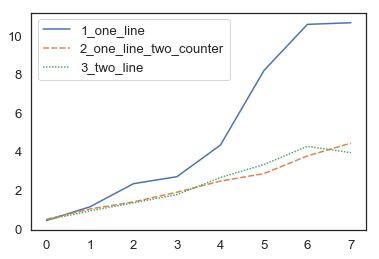

In [64]:
sns.lineplot(data = W_values_3_approachs)